# Dataset Integration

### Library loading

In [1]:
import scanpy as sc, anndata as ad, numpy as np, pandas as pd
from scipy import sparse
from anndata import AnnData
from matplotlib import pylab
import warnings
import yaml
import plotly.express as px

import os
import sys
import scanpy.external as sce

import matplotlib as plt

warnings.filterwarnings('ignore')

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
with open("../data/resources/rcParams.yaml") as f:
    rcParamsDict = yaml.full_load(f)
    for k in rcParamsDict["rcParams"]:
        print("{} {}".format(k,rcParamsDict["rcParams"][k]))
        plt.rcParams[k] = rcParamsDict["rcParams"][k]
    for k1 in set(list(rcParamsDict)).difference(set(["rcParams"])):
        print("{} {}".format(k1,rcParamsDict[k1]))

scanpy==1.9.3 anndata==0.8.0 umap==0.5.1 numpy==1.20.3 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.13.5 python-igraph==0.9.1 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.12
figure.dpi 80
savefig.dpi 500
figure.figsize [10, 10]
axes.facecolor None
figure.facecolor None
dotSize 20


# Configure paths

In [3]:
outdir = "../data/output"
homeDir = os.getenv("HOME")
with open("../data/resources/iPSC_lines_map.yaml", 'r') as f:
    iPSC_lines_map = yaml.load(f, Loader=yaml.FullLoader)["lines"]
colorsmap = dict(zip([i["newName"] for i in iPSC_lines_map.values()],[i["color"] for i in iPSC_lines_map.values()]))
sys.path.insert(1, homeDir+"/utils/")


figDir = "./figures"
if not os.path.exists(figDir):
   # Create a new directory because it does not exist
   os.makedirs(figDir)
    



sys.path.insert(1, homeDir+"/utils/")
from pBulk import *
from plotenrich import *

## Non integrated Datasets Multiplexing

In [4]:
Multiplexing = sc.read_h5ad(homeDir+'/data/output/adatas/MultiplexingPreprocessing_unscaled.h5ad')

In [5]:

adataCols = sc.read_h5ad(homeDir+'/data/output/adatas/adataPaga.h5ad')
ColorDict = dict(zip(adataCols.obs["leidenAnnotated"].cat.categories,adataCols.uns["leidenAnnotated_colors"]))
del adataCols
ColorDict

{'CajalR_like': '#1f77b4',
 'GlutamatergicNeurons_early': '#ff7f0e',
 'GlutamatergicNeurons_late': '#279e68',
 'Interneurons': '#d62728',
 'Interneurons_GAD2': '#aa40fc',
 'MigratingNeurons': '#8c564b',
 'Neurons': '#e377c2',
 'OuterRadialGliaAstrocytes': '#b5bd61',
 'ProliferatingProgenitors': '#17becf',
 'RadialGliaProgenitors': '#aec7e8',
 'intermediateProgenitors': '#ffbb78'}

## Non integrated Datasets cellplex

In [6]:
CellPlex = sc.read_h5ad(homeDir+'/data/cellplexDS/adatas/postfiltered_all.h5ad')

# Store original HVGs

In [7]:
HVGs = Multiplexing.var_names[Multiplexing.var["highly_variable"]].tolist()
len(HVGs)

3499

In [8]:
Multiplexing.X.data

array([ 1.,  1.,  1., ..., 23.,  4., 11.], dtype=float32)

In [9]:
CellPlex.X.data

array([48.,  1.,  9., ...,  1.,  1.,  1.], dtype=float32)

# Ad.combine

In [10]:
CellPlex.obs["dataset"] = CellPlex.obs["Run"]
CellPlex.obs["cellID_newName"] = CellPlex.obs["Consensus"].replace({"CTL01A":"CTL01"})
CellPlex.obs["cellID_newName_tag"] = CellPlex.obs["MultiSeq_call"]


In [11]:
Multiplexing.obs["cellID_newName_tag"] = np.nan

In [12]:
Combined = ad.concat([Multiplexing, CellPlex], label = "Project", keys = ["Multiplexing","Cellplex"])
Combined

AnnData object with n_obs × n_vars = 51029 × 19425
    obs: 'dataset', 'cellID_newName', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'cellID_newName_tag', 'Project'

# QCs

In [13]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
Combined.var["mt"] = Combined.var_names.str.startswith("MT-")
# ribosomal genes
Combined.var["ribo"] = Combined.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
Combined.var["hb"] = Combined.var_names.str.contains("^HB[^(P)]")
sc.pp.calculate_qc_metrics(
    Combined, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)


In [14]:
#sc.pp.normalize_total(Multiplexing, target_sum=1e6, exclude_highly_expressed=True, max_fraction=.1)
sc.pp.normalize_total(Combined)
sc.pp.log1p(Combined)
Combined.raw = Combined
Combined = Combined[:, Combined.var_names.isin(HVGs)]
Combined
sc.pp.regress_out(Combined, ['total_counts','pct_counts_mt'], n_jobs=4)
sc.pp.scale(Combined)

normalizing counts per cell
    finished (0:00:00)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:02:21)


In [15]:
sc.tl.pca(Combined, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:20)


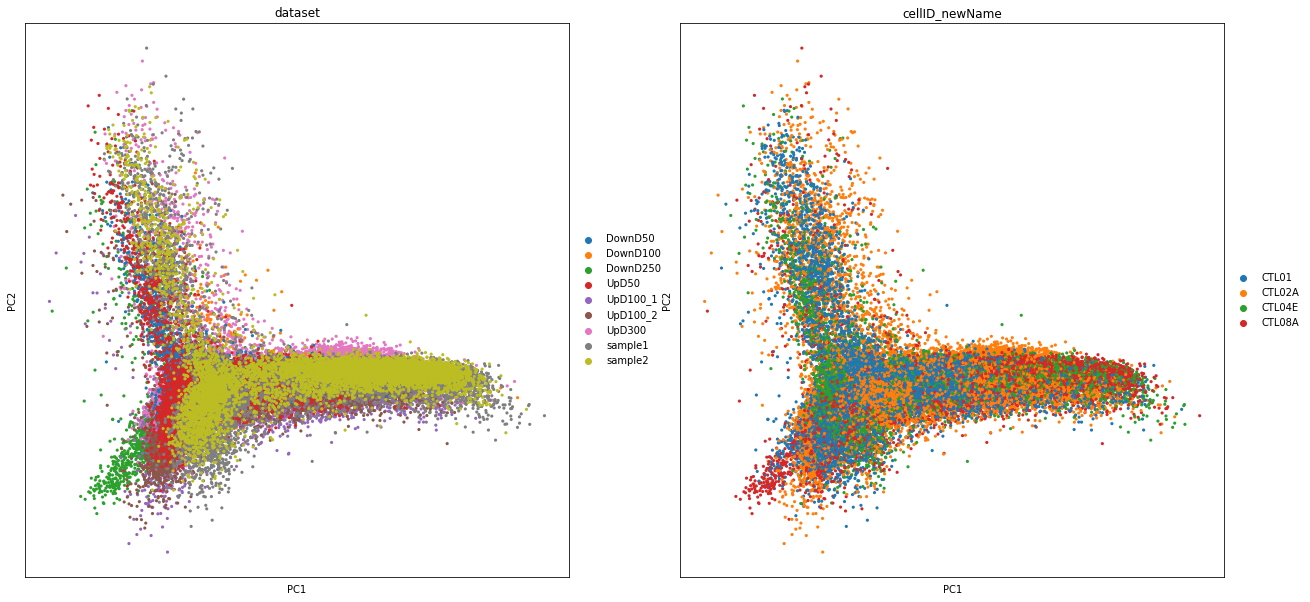

In [16]:
sc.pl.pca(Combined, color=['dataset','cellID_newName'], size = 40)

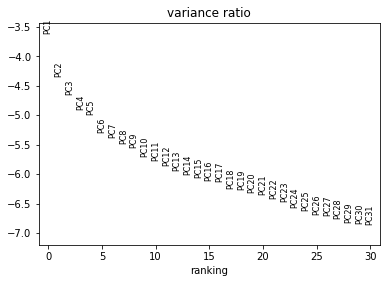

In [17]:
sc.pl.pca_variance_ratio(Combined, log=True)

In [18]:
sc.pp.neighbors(Combined, n_neighbors=20, n_pcs=7)
sc.tl.umap(Combined)


computing neighbors
    using 'X_pca' with n_pcs = 7
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:37)


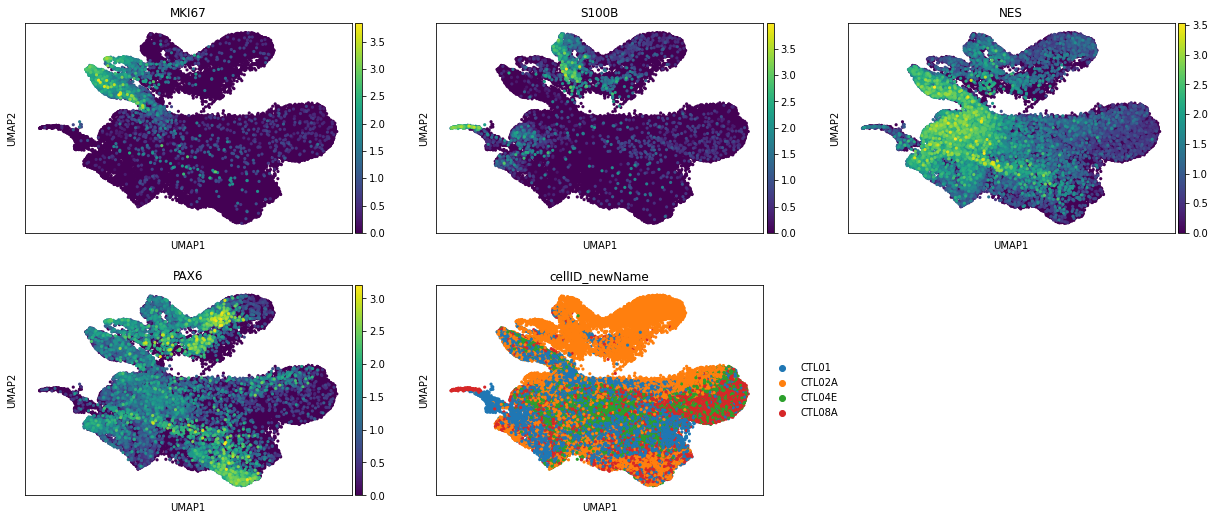

In [19]:

sc.pl.umap(Combined, color=['MKI67', 'S100B',"NES","PAX6",'cellID_newName'], ncols=3, size =40)

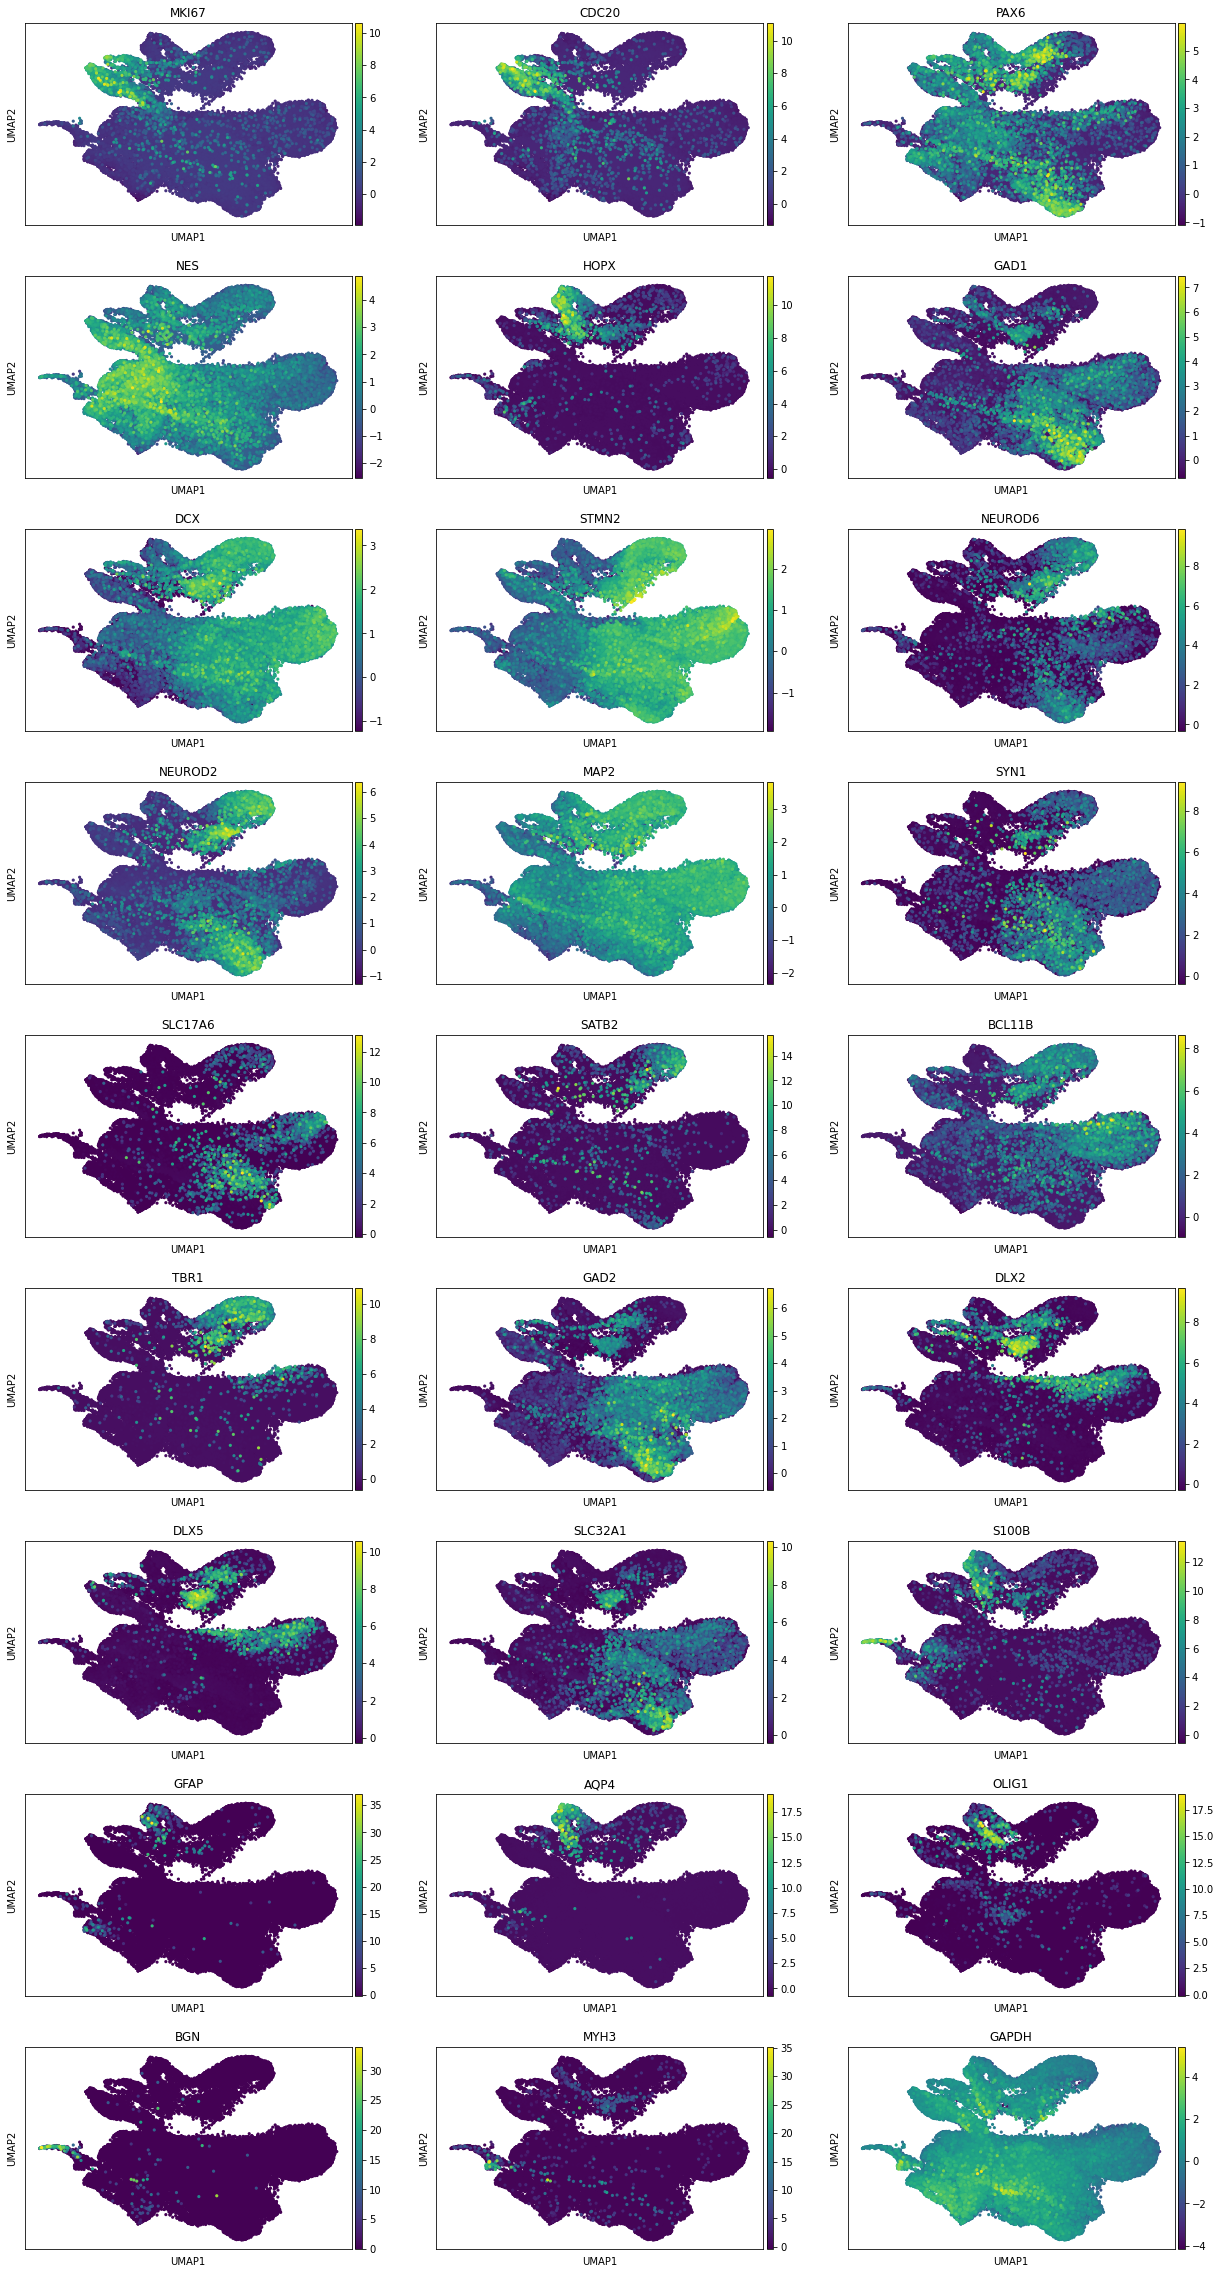

In [20]:
genes = pd.array(["MKI67","CDC20","PAX6","NES","HOPX","GAD1","DCX","STMN2","NEUROD6","NEUROD2","MAP2","SYN1","SLC17A6", "SATB2","BCL11B","TBR1", "GAD2","DLX2","DLX5","SLC32A1","S100B", "GFAP", "AQP4", "OLIG1","DCN", "BGN", "MYH3", "GAPDH"], dtype="category")

sc.pl.umap(Combined,color= genes[genes.isin(Combined.var_names) ], ncols=3, size=40, use_raw=False)


# Harmony

In [21]:
sce.pp.harmony_integrate(Combined, 'dataset', adjusted_basis="X_pca",  max_iter_harmony=20)

2024-05-08 10:09:41,260 - harmonypy - INFO - Iteration 1 of 20
2024-05-08 10:10:05,455 - harmonypy - INFO - Iteration 2 of 20
2024-05-08 10:10:49,052 - harmonypy - INFO - Iteration 3 of 20
2024-05-08 10:11:15,267 - harmonypy - INFO - Converged after 3 iterations


### Neighbors

In [22]:
sc.pp.neighbors(Combined,use_rep="X_pca",n_neighbors=100, n_pcs=15)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:03)


### UMAP

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:14)


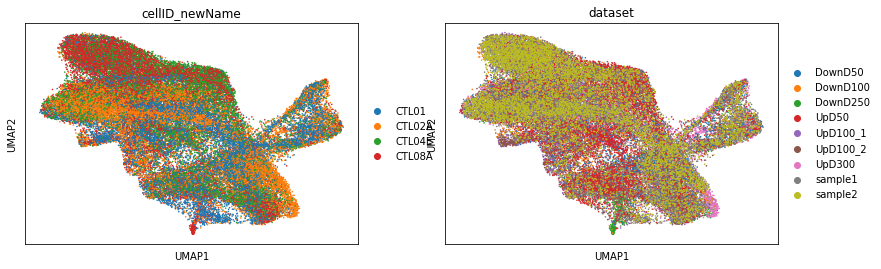

In [23]:
sc.tl.umap(Combined)
sc.pl.umap(Combined,color= ["cellID_newName","dataset"],size = 10, ncols=3, vmin='p1.5',vmax='p98.5' )


In [24]:
# Import annotation from processed adata
CellMappings = sc.read_h5ad(homeDir+'/data/output/adatas/adataPaga.h5ad').obs["leidenAnnotated"]
Combined.obs = pd.concat([Combined.obs,CellMappings], axis = 1)

In [25]:
Combined.obs["leidenAnnotated_transfer"] = np.where((Combined.obs["leidenAnnotated"].isna()) & (Combined.obs["Project"] == "Multiplexing"),"OffTarget",Combined.obs["leidenAnnotated"])

# prepare knn

In [26]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
TrainVal = Combined[Combined.obs["Project"] == "Multiplexing"].obsm["X_pca"]
TrainLab = Combined[Combined.obs["Project"] == "Multiplexing"].obs["leidenAnnotated_transfer"].to_numpy()
PredictVal = Combined[Combined.obs["Project"] == "Cellplex"].obsm["X_pca"]
neigh.fit(TrainVal, TrainLab)
NewLabels = neigh.predict(PredictVal)
Predicted = pd.DataFrame(NewLabels, index= Combined[Combined.obs["Project"] == "Cellplex"].obs_names, columns=["PredLabels"])
Combined.obs = pd.concat([Combined.obs, Predicted], axis = 1)
Combined.obs["PredLabels"] = np.where(Combined.obs["PredLabels"].isna(), Combined.obs["leidenAnnotated_transfer"], Combined.obs["PredLabels"])
#Remove offTarget celltypes
CombinedSS = Combined[Combined.obs["PredLabels"] != "OffTarget"]
CombinedSS.obs["PredLabels_project"] = CombinedSS.obs["PredLabels"].astype(str) + "_" + CombinedSS.obs["Project"] .astype(str)

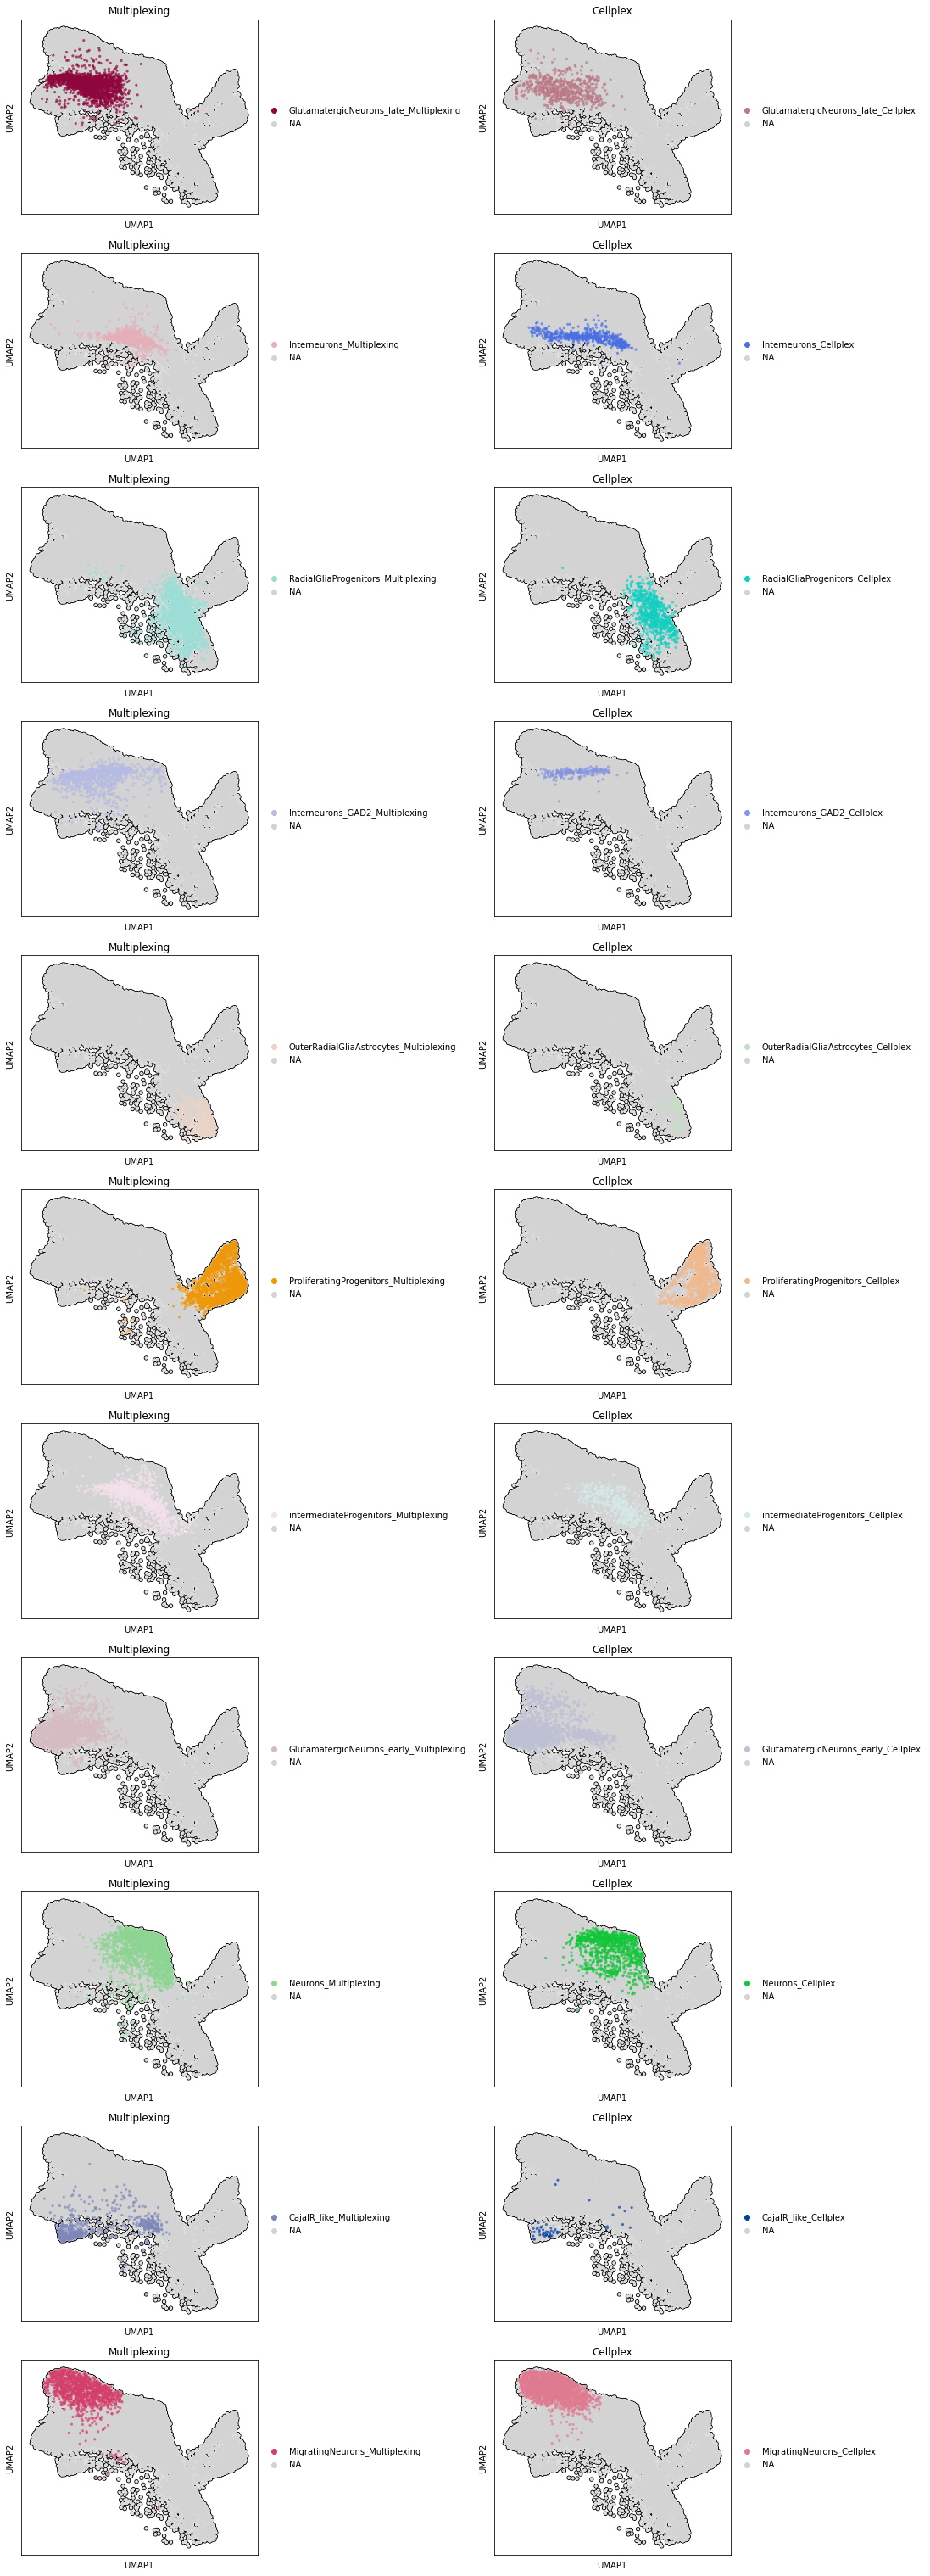

In [40]:
fig, axes = plt.subplots(len(CombinedSS.obs.PredLabels.unique()),2, figsize=(15,len(CombinedSS.obs.PredLabels.unique())*5))
plt.subplots_adjust(wspace=1)

for PredLabels in enumerate(CombinedSS.obs.PredLabels.unique()):
    SampleIDs = CombinedSS.obs.loc[CombinedSS.obs.PredLabels == PredLabels[1],"PredLabels_project"].unique().tolist()
    axes[PredLabels[0]][0] = sc.pl.umap(CombinedSS, size = 40, 
                                        add_outline=True,ncols=2, 
                                        color=["PredLabels_project"],
                                        title="{}".format(SampleIDs[0].split("_")[-1]),
                                        groups=SampleIDs[0], 
                                        vmin='p1', vmax='p99', show=False, ax=axes[PredLabels[0]][0])
    axes[PredLabels[0]][1] = sc.pl.umap(CombinedSS, size = 40, 
                                        add_outline=True,ncols=2, 
                                        color=["PredLabels_project"],
                                        title="{}".format(SampleIDs[1].split("_")[-1]),
                                        groups=SampleIDs[1], 
                                        vmin='p1', vmax='p99', show=False, ax=axes[PredLabels[0]][1])

fig.show()


In [ ]:
CombinedSSStage = CombinedSS[CombinedSS.obs["Project"] == "Cellplex"]
leidenOrder=["ProliferatingProgenitors","RadialGliaProgenitors","OuterRadialGliaAstrocytes","CajalR_like","Neurons","MigratingNeurons","GlutamatergicNeurons_early","GlutamatergicNeurons_late","Interneurons_GAD2","Interneurons"]

compositions = pd.DataFrame(CombinedSSStage.obs.groupby(["PredLabels","dataset"]).size())
compositions = compositions.reset_index().rename(columns={0:"number_of_cells"})
compositions["cells_fraction"] = compositions["number_of_cells"] / np.array(compositions.groupby("dataset")["number_of_cells"].sum()[compositions["dataset"].tolist()])

fig = px.bar(compositions, x="dataset", y="cells_fraction", color="PredLabels", hover_data=compositions,
                category_orders={"dataset":['test1', 'test2', 'test3'],
                                "PredLabels":leidenOrder},color_discrete_map=ColorDict, height=800,width=1000, template="plotly_white",title="CellPLex"
)

fig.update_traces(marker_line_color='black',
                    marker_line_width=1, opacity=1)

fig.update_layout(
yaxis = dict(tickfont = dict(size=30)),
xaxis = dict(tickfont = dict(size=30)))



fig.write_image(figDir+"/Compositions.CelltypeByStage."+paradigm+".pdf")
fig.show()



In [48]:
adataCols = sc.read_h5ad(homeDir+'/data/output/adatas/adataPaga.h5ad')
